# Computing distance figures from speeches

This notebooks reads embedded speech vectors and their metadata and computes different distance measures between the speeches

## Imports, methods etc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle
from tqdm import tqdm

### Data reading

In [3]:
def read_sentiment_csv(path):
    
    df = pd.read_csv(path)
    return df

In [17]:
def read_embeddings(path):

    with (open(path, "rb")) as openfile:
        while True:
            try:
                embeddings = pickle.load(openfile)
            except EOFError:
                break

    return embeddings

### Filtering and merging dataframes

In [40]:
def filter_df(df):

    # check if Date_datetime column exists
    if 'Date_datetime' not in df.columns:
        df['Date_datetime'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['speech_length'] = df['speech'].apply(lambda x: len(x) if type(x) == str else 0)
    # compute week
    df['week'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.week) if x.week > 9 else '0' + str(x.week)))
    df['month'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.month) if x.month > 9 else '0' + str(x.month)))
    # #filter out speeches with less than 100 words
    df = df[df['speech_length'] > 200]
    #filter out speeches where the speaker is not a mp
    df = df[df['Speaker_MP'] == 'MP']
    df = df[df['Speaker_role'] == 'Regular']
    #reset index
    df = df.reset_index(drop=True)

    return df

In [18]:
def merge_embeds_and_df(df, embeddings):

    merged_df = df.merge(embeddings, left_on='ID', right_on=embeddings.index, how='inner')

    return merged_df

### Methods for monthly analysis

In [78]:
def new_monthly_analysis_df():

    return pd.DataFrame(columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches'])

def new_speakers_df():

    return pd.DataFrame(columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])

def monthly_data(month, df):

    df_m = df[df['month'] == month]
    vectors_m = df_m['embeddings'].values
    vectors_m = np.array([np.array(x) for x in vectors_m])

    return df_m, vectors_m

def monthly_party_figures(df_m, monthly_speech_mean_vector, monthly_speech_median_vector):

    parties = df_m['Speaker_party'].unique()
    #remove null party
    parties = [p for p in parties if str(p) != 'nan']
    #calculate mean vector for each party
    party_mean_vectors = []
    party_median_vectors = []
    for p in parties:
        #filter vectors to only include vectors where speaker party is p
        vectors_p = df_m[df_m['Speaker_party'] == p]['embeddings'].values
        vectors_p = np.array([np.array(x) for x in vectors_p])
        #calculate mean vector for party p
        mean_vector_p = np.mean(vectors_p, axis=0)
        party_mean_vectors.append(mean_vector_p)
        #calculate median vector for party p
        median_vector_p = np.median(vectors_p, axis=0)
        party_median_vectors.append(median_vector_p)
    #compute party weights
    party_weights = np.array([len(df_m[df_m['Speaker_party'] == p]) for p in parties])
    party_weights = party_weights / np.sum(party_weights)
    #compute party vector distances to mean vector
    party_distances = np.array([np.linalg.norm(mean_vector_p - monthly_speech_mean_vector) for mean_vector_p in party_mean_vectors])
    party_distances = party_distances @ party_weights.T
    mean_weighted_party_distance = np.mean(party_distances)
    #compute party vector distances to median vector
    party_distances_median = np.array([np.linalg.norm(median_vector_p - monthly_speech_median_vector) for median_vector_p in party_median_vectors])
    median_party_distance = np.median(party_distances_median)

    return mean_weighted_party_distance, median_party_distance

def monthly_speaker_figures(df_m, monthly_speech_mean_vector, monthly_speech_median_vector):

    #list distinct speakers in df_w
    speakers = df_m['Speaker_name'].unique()
    #new dataframe for speaker monthly stats
    speakers_monthly_stats = new_speakers_df()
    #calculate mean vector for each speaker
    speaker_mean_vectors = []
    speaker_median_vectors = []
    for s in speakers:
        #filter vectors to only include vectors where speaker is s
        vectors_s = df_m[df_m['Speaker_name'] == s]['embeddings'].values
        vectors_s = np.array([np.array(x) for x in vectors_s])
        #calculate mean vector for speaker s
        mean_vector_s = np.mean(vectors_s, axis=0)
        speaker_mean_vectors.append(mean_vector_s)
        #calculate median vector for speaker s
        median_vector_s = np.median(vectors_s, axis=0)
        speaker_median_vectors.append(median_vector_s)
        #add speaker to df_speakers
        speaker_row = pd.DataFrame([[s, m, np.linalg.norm(mean_vector_s - monthly_speech_mean_vector), len(vectors_s)]], columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])
        speakers_monthly_stats = pd.concat([speakers_monthly_stats, speaker_row])
    #compute speaker weights
    speaker_weights = np.array([len(df_m[df_m['Speaker_name'] == s]) for s in speakers])
    speaker_weights = speaker_weights / np.sum(speaker_weights)
    #compute speaker vector distances to mean vector
    speaker_distances = np.array([np.linalg.norm(mean_vector_s - monthly_speech_mean_vector) for mean_vector_s in speaker_mean_vectors])
    speaker_distances = speaker_distances @ speaker_weights.T
    spkrm = np.sum(speaker_distances)
    #compute speaker vector distances to median vector
    speaker_distances_median = np.array([np.linalg.norm(median_vector_s - monthly_speech_median_vector) for median_vector_s in speaker_median_vectors])
    spkr_median = np.median(speaker_distances_median)

    return spkrm, spkr_median, speakers_monthly_stats

def monthly_cosine_similarities(vectors_m, monthly_speech_mean_vector, monthly_speech_median_vector):

    #calculate cosine similarities
    
    monthly_cos_sim_to_mean = cosine_similarity(vectors_m, monthly_speech_mean_vector.reshape(1, -1))
    monthly_cos_sim_m_to_median = cosine_similarity(vectors_m, monthly_speech_median_vector.reshape(1, -1))
    #calculate mean and median cosine similarities
    mean_cos_sim = np.mean(monthly_cos_sim_to_mean)
    median_cos_sim = np.median(monthly_cos_sim_m_to_median)
    
    return mean_cos_sim, median_cos_sim

## Running the Analysis

### Data locations

In [60]:
__location__ = os.path.abspath("")
sentiment_path = os.path.join(__location__, '..', 'data', 'DHH23_csvs_with_sentiment', 'ParlaMint-HU_with_sentiment.csv')
speaker_dump_path = os.path.join(__location__, '..', 'data', 'speakers.csv')
pklpath = os.path.abspath(os.path.join(__location__, '..', 'data', 'ParlaMint_HU_embeddings_truncated.pkl'))


### Read sentiment CSV

In [64]:
df = read_sentiment_csv(sentiment_path)
#filter the dataframe
df = filter_df(df)
df.head()
print(len(df))

/var/folders/y2/sg8vx_vs2bx7n1qn9xgb70800000gn/T/ipykernel_36969/418609971.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


42470


### Read the embedded vectors

In [62]:
embeddings = read_embeddings(pklpath)
df_embeddings = pd.DataFrame(index=embeddings.keys())
df_embeddings['embeddings'] = embeddings.values()
df_embeddings.head(2)
print(len(df_embeddings))

104521


### Merge data frames

In [83]:
mergeddf = merge_embeds_and_df(df, df_embeddings)
mergeddf.head(2)


,Unnamed: 0,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,...,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,Date_datetime,speech_length,week,month,embeddings
0,1,u2017-11-15-1,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,...,M,1965.0,"Köszönöm szépen a lehetőséget, elnök úr. Tiszt...",Tisztelt Országgyűlés! Tisztelt Képviselőtárs...,0.639648,2017-11-15,8220,2017-46,2017-11,"[0.014274968, 9.5067546e-05, -0.011200614, -0...."
1,5,u2017-11-15-5,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,...,M,1966.0,Tisztelt Elnök Úr! Tisztelt Ház! Tisztelt Képv...,A kiemelt hely semmi esetre sem szól a személ...,-0.912598,2017-11-15,6437,2017-46,2017-11,"[-0.021701507, 0.15527691, -0.015390828, -0.03..."


### Run monthly analysis

In [79]:
#list distinct months in df
months = mergeddf['month'].unique()
#initialize dfs for storing results
monthly_means = new_monthly_analysis_df()
monthly_medians = new_monthly_analysis_df()
df_speakers = new_speakers_df()

#iterate over months
for m in tqdm(months):
    #filter df to only include speeches in month m
    df_m, vectors_m = monthly_data(m, mergeddf)
    number_of_speeches = len(df_m)
    
    #calculate mean, median vector for month m
    mean_vector_m = np.mean(vectors_m, axis=0)
    median_vector_m = np.median(vectors_m, axis=0)
    
    #calculate mean, median distances for parties, speakers
    weighted_mean_party_distance, median_party_distance = monthly_party_figures(df_m, mean_vector_m, median_vector_m)
    weighted_mean_speaker_distance, median_speaker_distance, speakers_monthly_stats = monthly_speaker_figures(df_m, mean_vector_m, median_vector_m)
    df_speakers = pd.concat([df_speakers, speakers_monthly_stats])
    
    #compute mean cosine similarity for month m
    mean_cos_sim, median_cos_sim = monthly_cosine_similarities(vectors_m, mean_vector_m, median_vector_m)

    #concatenate monthly means
    monthly_mean_row = pd.DataFrame([[m, mean_cos_sim, weighted_mean_party_distance, weighted_mean_speaker_distance, number_of_speeches]], columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches'])
    monthly_means = pd.concat([monthly_means, monthly_mean_row])
    
    #concatenate monthly medians
    monthly_median_row = pd.DataFrame([[m, median_cos_sim, median_party_distance, median_speaker_distance, number_of_speeches]], columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches'])
    monthly_medians = pd.concat([monthly_medians, monthly_median_row])

df_speakers['monthly_mean_distance'] = df_speakers['monthly_distance'] / df_speakers['number_of_speeches']

100%|██████████| 84/84 [00:13<00:00,  6.32it/s]


### Plot mean figures

     month   cos_sim  party_distance  speaker_distance number_of_speeches
0  2014-05  0.874321        0.000000          0.000000                  4
1  2014-06  0.716327        0.223167          0.837033                592
2  2014-07  0.773145        0.415039          1.162836                 85
3  2014-09  0.705261        0.267626          0.963052                365
4  2014-10  0.717028        0.242008          0.828699                570


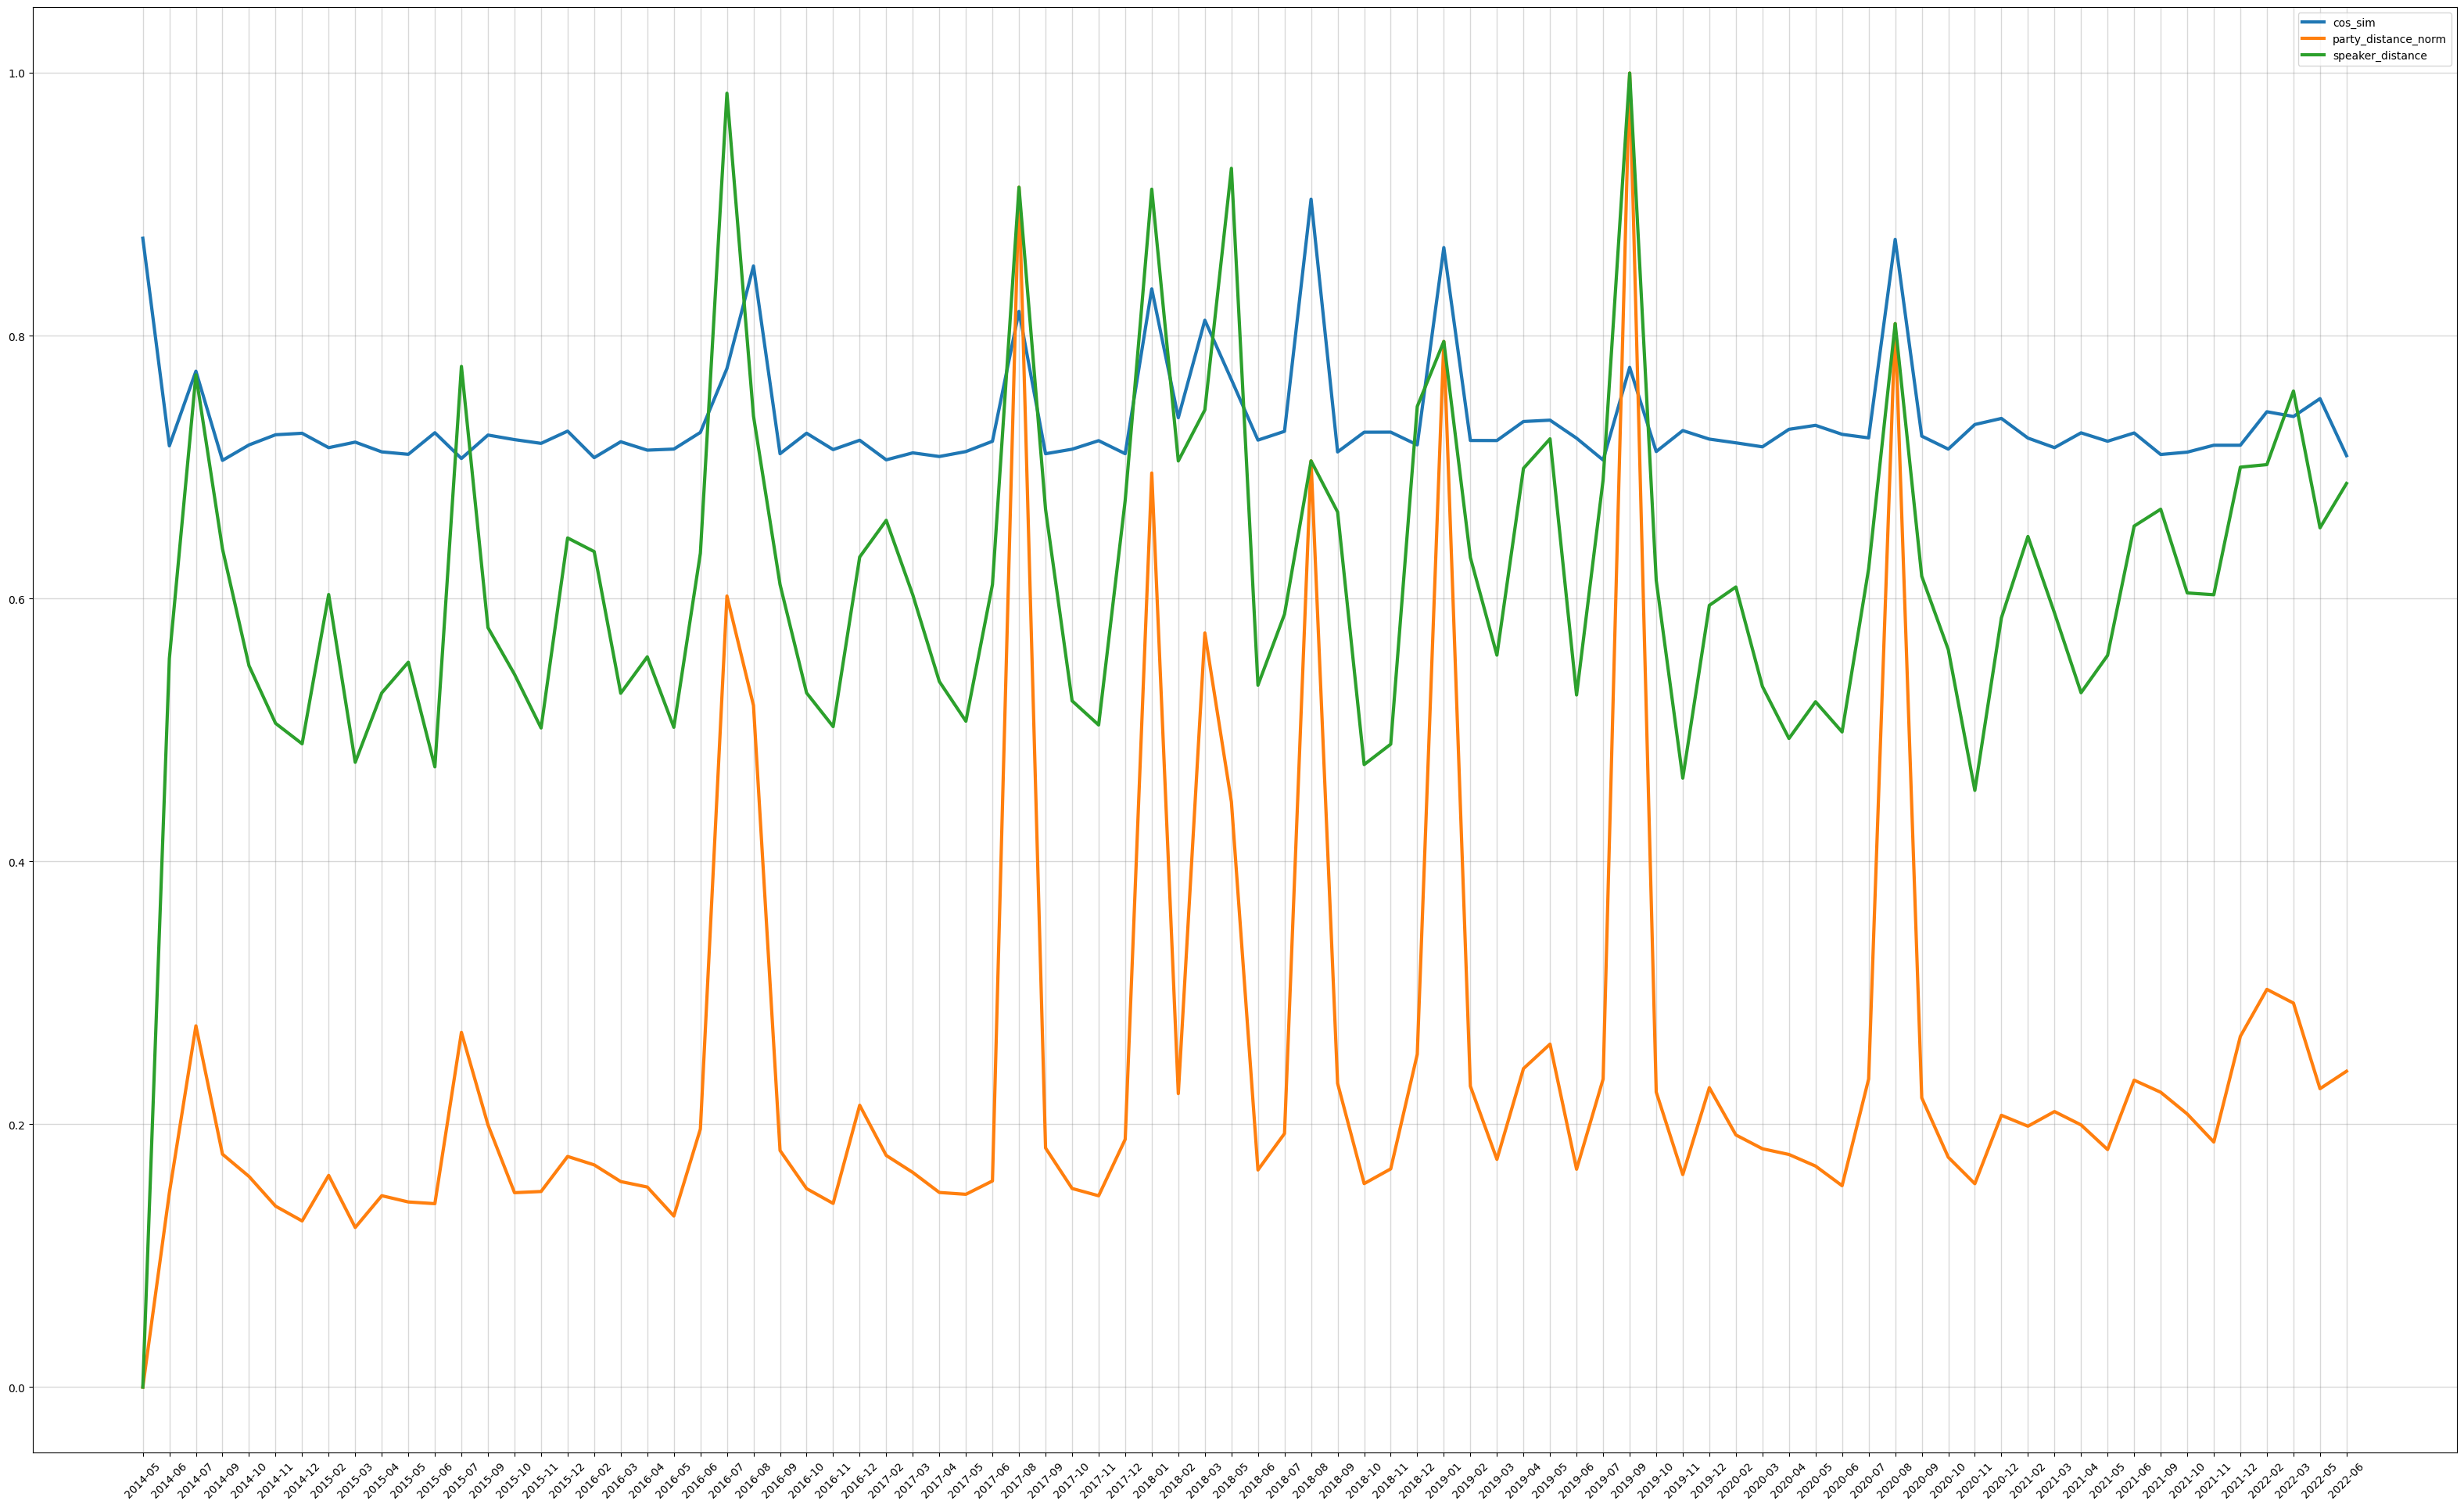

In [80]:
monthly = monthly_means.sort_values(by=['month']).reset_index(drop=True)
print(monthly.head())
monthly['party_distance_norm'] = monthly['party_distance'] / np.max(monthly['party_distance'])
monthly['speaker_distance_norm'] = monthly['speaker_distance'] / np.max(monthly['speaker_distance'])
plt.figure(figsize=(40,24))
plt.plot(monthly['month'], monthly['cos_sim'], linewidth=3)
plt.plot(monthly['month'], monthly['party_distance_norm'], linewidth=3)
plt.plot(monthly['month'], monthly['speaker_distance_norm'], linewidth=3)
plt.xticks(rotation=45)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.legend(['cos_sim', 'party_distance_norm', 'speaker_distance'])
plt.show()


### Plot median figures

(84,)
(84,)
(84,)
<class 'numpy.ndarray'>
2.851033499643621


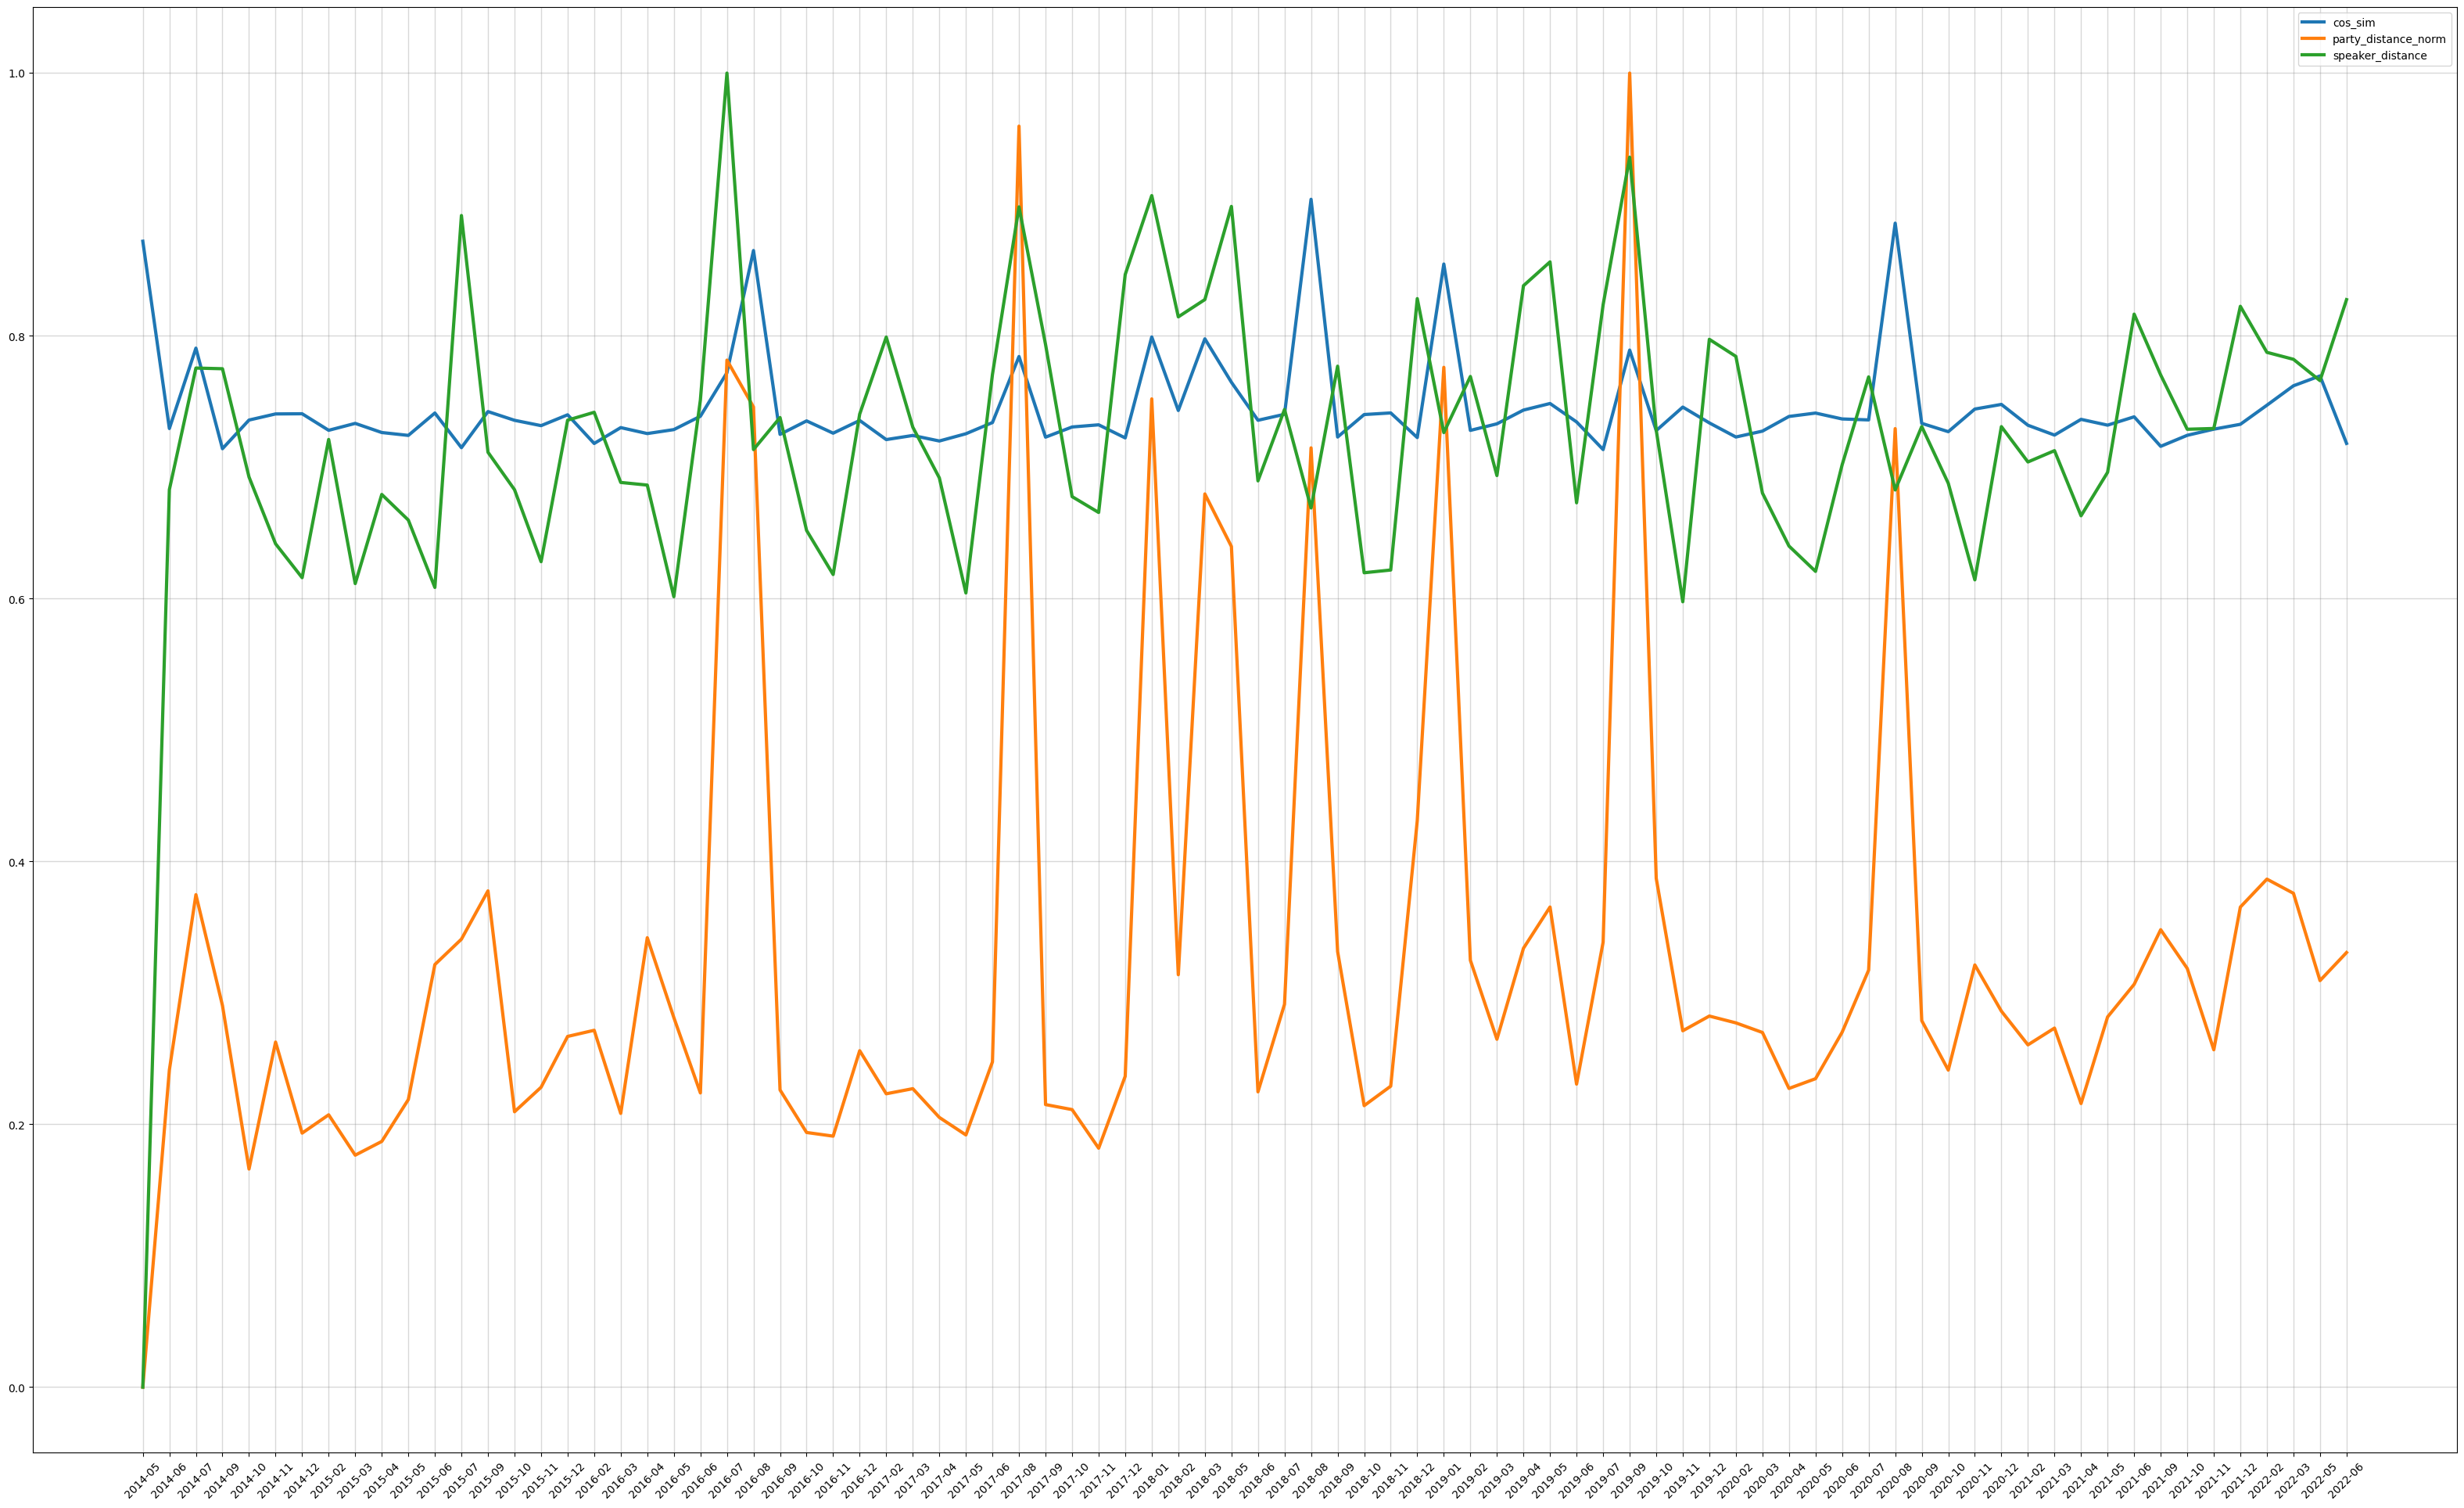

In [81]:
monthly_median = monthly_medians.sort_values(by=['month']).reset_index(drop=True)
monthly_median['party_distance_norm'] = monthly_median['party_distance'] / np.max(monthly_median['party_distance'])
monthly_median['speaker_distance_norm'] = monthly_median['speaker_distance'] / np.max(monthly_median['speaker_distance'])
monthly_median['number_of_speeches_norm'] = monthly_median['number_of_speeches'] / np.max(monthly_median['number_of_speeches'])
monthly_speeches_norm = (monthly_median['number_of_speeches'] / np.max(monthly_median['number_of_speeches'])).to_numpy()
monthly_speeches_norm = monthly_speeches_norm.astype(np.float64) * 1000
plt.figure(figsize=(40,24))
print(monthly_median['month'].shape)
print(monthly_median['number_of_speeches_norm'].shape)
print(monthly_speeches_norm.shape)
print(type(monthly_speeches_norm))
print(monthly_speeches_norm[0])
plt.plot(monthly_median['month'], monthly_median['cos_sim'], linewidth=3)
plt.plot(monthly_median['month'], monthly_median['party_distance_norm'], linewidth=3)
plt.plot(monthly_median['month'], monthly_median['speaker_distance_norm'], linewidth=3)
# plt.scatter(x=monthly_median['month'], y=monthly_median['party_distance_norm'], s=monthly_speeches_norm, color='blue')
plt.xticks(rotation=45)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.legend(['cos_sim', 'party_distance_norm', 'speaker_distance'])
plt.show()

## Save Speakers CSV

In [11]:
# save speakers csv
df_speakers.to_csv(speaker_dump_path, index=False)